# Stock data with Alphavantage.co data

This notebook contains a few experiments to work with the API of Alphavantage.co which seems the currently best stock data source. For Python there is fix-yahoo-finance which does what the name says, but at least for the immediate future us personal stock data grabbers seem to be well served by Alphavantage.

In [1]:
import json
import os
from pprint import pformat

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import datetime
import matplotlib.dates as mdates

#python3 -m pip install mpl_finance
from mpl_finance import candlestick_ohlc

#python3 -m pip install ipywidgets
from ipywidgets import widgets

In [2]:
apikey="demo"
try:
    with open(os.path.join("./stocksconfig.json")) as f:
        config = json.load(f)
        apikey = config['alphavantage']['apikey']
        config['alphavantage']['apikey'] = '****************'
        print("This is how the config file looks like:\n\n{}".format(pformat(config)))
except FileNotFoundError: #IOError
    print("Get or retrieve your API Key from https://www.alphavantage.co/support/#api-key")
    #input_variable = widgets.Text(value='', placeholder='0123456789abcdef', description='API Key:', disabled=False )
    #def bind_input_to_output(sender):
    #    apikey = input_variable.value
    #    print(apikey)
    #input_variable.on_submit(bind_input_to_output)
    #display(input_variable)

#print("apikey: ", apikey)

This is how the config file looks like:

{'alphavantage': {'apikey': '****************'}}


## Grab data

This notebook is using the requests library docs.python-requests.org to query the API for json data.
Then a few transformations are done to come up with a more generic dataframe.

In [3]:
# the endpoint is for TIME_SERIES_DAILY_ADJUSTED
# https://www.alphavantage.co/documentation/#dailyadj
import requests
r = requests.get(url='https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=^GDAXI&apikey='+ apikey)
#I like to keep such calls in a separate cell so I can work on the object locally

In [4]:
df = pd.DataFrame.from_dict(r.json()['Time Series (Daily)'], orient="index")

# the data needs to be casted into non-strings
df=df.astype(float) #https://stackoverflow.com/a/31495326

# and the index need to be proper dates
df.index = pd.to_datetime(df.index)
# and for easier consumption later the index is added as a column
df['Date'] = df.index.map(mdates.date2num)

# finally some more generic column names
df = df.rename(columns={'1. open': 'Open', '2. high': 'High', '3. low': 'Low', '5. adjusted close': 'Close'})

#a brief glimpse into the data
df.head()


,Open,High,Low,4. close,Close,6. volume,7. dividend amount,8. split coefficient,Date
2018-02-27,12573.6504,12577.5596,12436.1299,12490.7305,12490.7305,89864600.0,0.0,1.0,736752.0
2018-02-28,12427.4600,12516.9199,12417.9600,12435.8496,12435.8496,93391300.0,0.0,1.0,736753.0
2018-03-01,12386.4004,12387.8799,12143.1396,12190.9404,12190.9404,113680600.0,0.0,1.0,736754.0
2018-03-02,12051.8896,12081.4004,11877.6602,11913.7100,11913.7100,120480800.0,0.0,1.0,736755.0
2018-03-05,11831.5703,12110.1797,11830.9805,12090.8701,12090.8701,109920600.0,0.0,1.0,736758.0


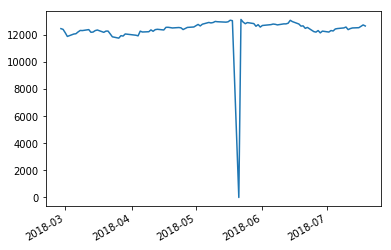

In [5]:
#But there is a plroblem
df['Close'].plot()

In [6]:
# an inspection of the dataframe reveals a zero 'price'
df.describe()

,Open,High,Low,4. close,Close,6. volume,7. dividend amount,8. split coefficient,Date
count,100.000000,100.000000,100.000000,100.000000,100.000000,1.000000e+02,100.0,100.0,100.000000
mean,12412.973231,12479.458778,12331.558020,12409.410391,12409.410391,9.874846e+07,0.0,1.0,736823.850000
std,1293.179215,1297.154386,1287.107217,1292.977644,1292.977644,3.579606e+07,0.0,0.0,42.090181
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,1.0,736752.000000
25%,12322.247275,12380.745125,12204.732150,12305.797600,12305.797600,8.447128e+07,0.0,1.0,736788.750000
50%,12534.570350,12581.754850,12469.725100,12540.615250,12540.615250,9.894355e+07,0.0,1.0,736824.500000
75%,12788.652850,12832.219950,12714.402600,12790.909925,12790.909925,1.101684e+08,0.0,1.0,736859.250000
max,13138.830100,13204.309600,13061.769500,13169.919900,13169.919900,2.576705e+08,0.0,1.0,736894.000000


In [7]:
# when was that?
df.idxmin(axis=0)

Open                   2018-05-21
High                   2018-05-21
Low                    2018-05-21
4. close               2018-05-21
Close                  2018-05-21
6. volume              2018-04-27
7. dividend amount     2018-02-27
8. split coefficient   2018-02-27
Date                   2018-02-27
dtype: datetime64[ns]

In [8]:
# here is the row for that particular index
df[df.index.to_pydatetime() == datetime.datetime(2018,5,21)]

,Open,High,Low,4. close,Close,6. volume,7. dividend amount,8. split coefficient,Date
2018-05-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,736835.0


In [9]:
# for the supplied list of columns, remove every row with at least one column being zero
# this drops some data, which might suit most usecases

#https://codereview.stackexchange.com/a/185390
df = df[(df[['Open', 'High', 'Low', 'Close']] != 0).all(axis=1)]
df.describe()

,Open,High,Low,4. close,Close,6. volume,7. dividend amount,8. split coefficient,Date
count,99.000000,99.000000,99.000000,99.000000,99.000000,9.900000e+01,99.0,99.0,99.000000
mean,12538.356799,12605.513917,12456.119212,12534.757971,12534.757971,9.974592e+07,0.0,1.0,736823.737374
std,318.168361,307.530476,325.834830,318.772707,318.772707,3.455323e+07,0.0,0.0,42.289234
min,11831.570300,11961.160200,11726.620100,11787.259800,11787.259800,0.000000e+00,0.0,1.0,736752.000000
25%,12323.194800,12382.110350,12222.674800,12306.665050,12306.665050,8.493115e+07,0.0,1.0,736788.500000
50%,12538.160200,12583.790000,12472.980500,12540.730500,12540.730500,9.907000e+07,0.0,1.0,736824.000000
75%,12791.155300,12836.899900,12714.774900,12794.689950,12794.689950,1.104162e+08,0.0,1.0,736859.500000
max,13138.830100,13204.309600,13061.769500,13169.919900,13169.919900,2.576705e+08,0.0,1.0,736894.000000


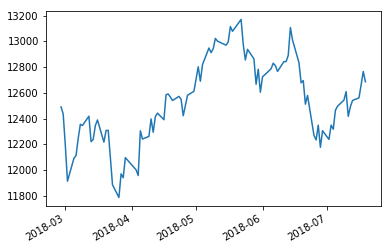

In [10]:
# seeing is believing:
df['Close'].plot()

In [11]:
#df3 = df2.rename(columns={'oldName1': 'newName1', 'oldName2': 'newName2'})
#'1. open', '2. high', '3. low', '4. close', '5. adjusted close'
#'1. open': 'open', '2. high': 'high', '3. low': 'low'", '5. adjusted close': 'close'
#df3 = df2.rename(columns={'1. open': 'Open', '2. high': 'High', '3. low': 'Low', '5. adjusted close': 'Close'})
#df3['Date'] = df3.index #for single index
#for multiindex see https://stackoverflow.com/a/46920777

#df3['Date'] = df3.index.map(mdates.date2num)
ohlc = df[['Date','Open','High','Low','Close']]

ohlc.head()


,Date,Open,High,Low,Close
2018-02-27,736752.0,12573.6504,12577.5596,12436.1299,12490.7305
2018-02-28,736753.0,12427.4600,12516.9199,12417.9600,12435.8496
2018-03-01,736754.0,12386.4004,12387.8799,12143.1396,12190.9404
2018-03-02,736755.0,12051.8896,12081.4004,11877.6602,11913.7100
2018-03-05,736758.0,11831.5703,12110.1797,11830.9805,12090.8701


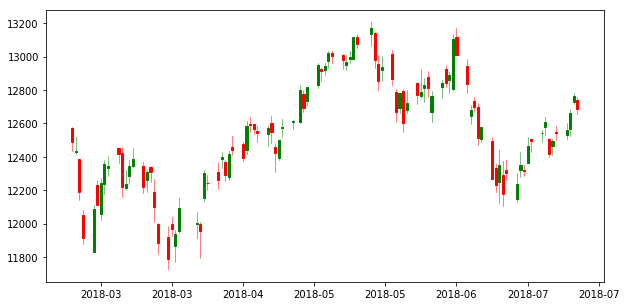

In [12]:
# finally a candlestick chart

#mpl_finance.candlestick_ohlc wants a specific input
ohlc = df[['Date','Open','High','Low','Close']]

f1, ax = plt.subplots(figsize = (10,5))

# plot the candlesticks
candlestick_ohlc(ax, ohlc.values, width=.6, colorup='green', colordown='red')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.show()